## XGBoost Sales Prediction

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn import model_selection
from sklearn.model_selection import train_test_split,RepeatedKFold,cross_val_score
from plotnine import ggplot, aes, geom_tile, scale_fill_gradient, theme_minimal, theme, geom_boxplot
from plotnine import ggsave, scale_y_reverse, labs, scale_fill_gradient2,geom_line,geom_point,scale_color_manual,geom_text
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score,roc_curve, auc
from sklearn.neighbors import NearestNeighbors,KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
import xgboost as xgb
from tqdm import tqdm
import Standardizer
import Encoder
import Interaction
from sklearn.metrics import make_scorer, mean_absolute_percentage_error, mean_absolute_error,mean_squared_error,explained_variance_score
import shap

## College

In [2]:
college_data = pd.read_csv('location_class_college.csv')
data = college_data
data
college_metadata = data[['date','store_id','location_class']]
#data.info()
response = data[['total.sales','split']]
features = data.drop(columns=['total.sales'])
train_features,test_features = features[features['split']=='train'].drop(['split', 'store_id', 'date','location_class'], axis=1),features[features['split']=='test'].drop(['split', 'store_id', 'date','location_class'], axis=1)
train_response,test_response = response[response['split']=='train'].drop(['split'], axis=1),response[response['split']=='test'].drop(['split'], axis=1)

In [3]:
train_data = pd.concat([train_response, train_features], axis=1)
test_data = pd.concat([test_response, test_features], axis=1)

In [4]:
train_features,test_features = Encoder.encode_non_numeric(train_features),Encoder.encode_non_numeric(test_features)
train_features = Interaction.add_interaction_term(train_features, day_col='dayofweek', promo_col='total_promotions', new_col_name='day_promo_interaction')
test_features = Interaction.add_interaction_term(test_features, day_col='dayofweek', promo_col='total_promotions', new_col_name='day_promo_interaction')

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:53<00:00,  5.38s/it]


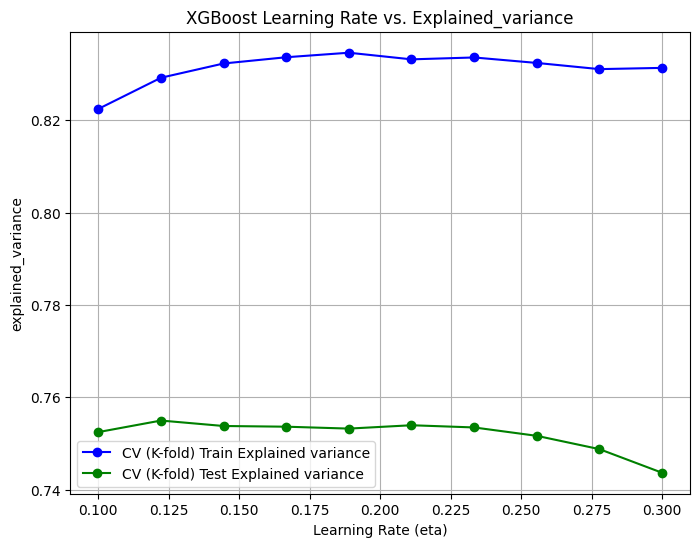

In [5]:
X_train = train_features
Y_train = train_response
X_test = test_features
Y_test = test_response

# Standardize Data (Assuming standardize_data() function works as expected)
X_train_stand, Y_train_stand, X_train_stand_scaler, Y_train_stand_scaler = Standardizer.standardize_data(features=X_train, response=Y_train)
X_test_stand, Y_test_stand, X_test_stand_scaler, Y_test_stand_scaler = Standardizer.standardize_data(features=X_test, response=Y_test)

Y_train_stand = Y_train
Y_test_stand = Y_test

# Define range of learning rates (eta)
eta_values = np.linspace(0.1, 0.3, 10)  # From 0.01 to 0.3 in 10 steps

# Lists to store errors
train_error = []
test_error = []

# Cross-validation setup
cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)

# Loop through different eta values
for eta in tqdm(eta_values):
    xgb_model = xgb.XGBRegressor(learning_rate=eta, n_estimators=np.sqrt(len(Y_train_stand)).astype(int), max_depth=5, random_state=42, eval_metric="rmse")


    # Fit the model
    xgb_model.fit(X_train_stand, Y_train_stand)

    # Cross-validation scores
    train_mse = cross_val_score(xgb_model, X_train_stand, Y_train_stand, cv=cv, scoring='explained_variance').mean()
    test_mse = cross_val_score(xgb_model, X_test_stand, Y_test_stand, cv=cv, scoring='explained_variance').mean()

    # Append errors
    train_error.append((train_mse))
    test_error.append((test_mse))


# Plot results
plt.figure(figsize=(8, 6))
plt.plot(eta_values, train_error, 'b-', marker='o', label='CV (K-fold) Train Explained variance')
plt.plot(eta_values, test_error, 'g-', marker='o', label='CV (K-fold) Test Explained variance')
plt.xlabel('Learning Rate (eta)')
plt.ylabel('explained_variance')
plt.title("XGBoost Learning Rate vs. Explained_variance")
plt.legend()
plt.grid()
plt.savefig("College_XGBoost_LearningRate_vs_Explained_variance.png", format="png", dpi=300)
plt.show()

In [6]:
college = pd.DataFrame()
college['Eta'] = eta_values
college['Train'] = train_error
college["Test"] = test_error
college.to_csv('college_learn_rate.csv')

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:54<00:00, 10.97s/it]


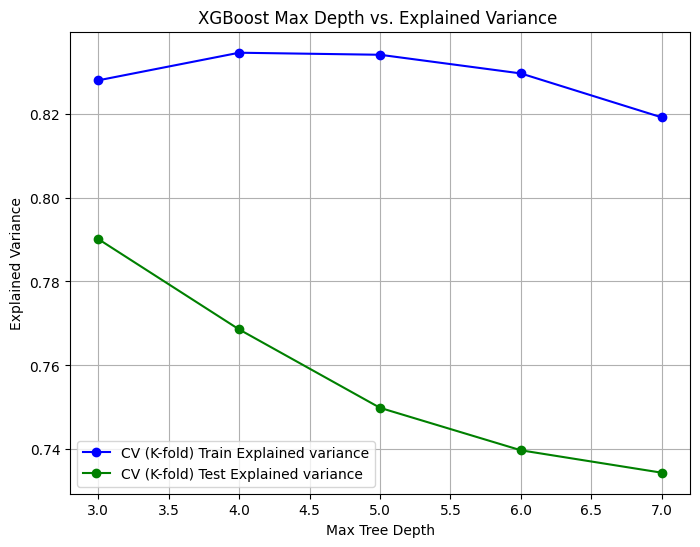

In [8]:
X_train = train_features
Y_train = train_response
X_test = test_features
Y_test = test_response

# Standardize Data (Assuming standardize_data() function works as expected)
X_train_stand, Y_train_stand, X_train_stand_scaler, Y_train_stand_scaler = Standardizer.standardize_data(features=X_train, response=Y_train)
X_test_stand, Y_test_stand, X_test_stand_scaler, Y_test_stand_scaler = Standardizer.standardize_data(features=X_test, response=Y_test)
# Keep original response
Y_train_stand = Y_train
Y_test_stand = Y_test

# Define fixed learning rate
eta = 0.175
depth_values = range(3, 8)

# Lists to store errors
train_error = []
test_error = []

# Cross-validation setup
cv = RepeatedKFold(n_splits=5, n_repeats=20, random_state=42)

# Loop over tree depths
for depth in tqdm(depth_values):
    xgb_model = xgb.XGBRegressor(
        learning_rate=eta,
        n_estimators=int(np.sqrt(len(Y_train_stand))),
        max_depth=depth,
        random_state=42,
        eval_metric="rmse"
    )

    # Fit the model
    xgb_model.fit(X_train_stand, Y_train_stand)

    # Cross-validation scores
    train_mse = cross_val_score(xgb_model, X_train_stand, Y_train_stand, cv=cv, scoring='explained_variance').mean()
    test_mse = cross_val_score(xgb_model, X_test_stand, Y_test_stand, cv=cv, scoring='explained_variance').mean()

    # Append errors
    train_error.append(train_mse)
    test_error.append(test_mse)

# Plot results
plt.figure(figsize=(8, 6))
plt.plot(depth_values, train_error, 'b-', marker='o', label='CV (K-fold) Train Explained variance')
plt.plot(depth_values, test_error, 'g-', marker='o', label='CV (K-fold) Test Explained variance')
plt.xlabel('Max Tree Depth')
plt.ylabel('Explained Variance')
plt.title("XGBoost Max Depth vs. Explained Variance ")
plt.legend()
plt.grid()
plt.savefig("College_XGBoost_MaxDepth_vs_Explained_variance.png", format="png", dpi=300)
plt.show()

   Actual Sales  Predicted Sales
0       1323.22      1482.273193
1       1178.19       864.928528
2        939.76       520.098694
3       1531.97      1534.996582
4       2076.36      2705.733643


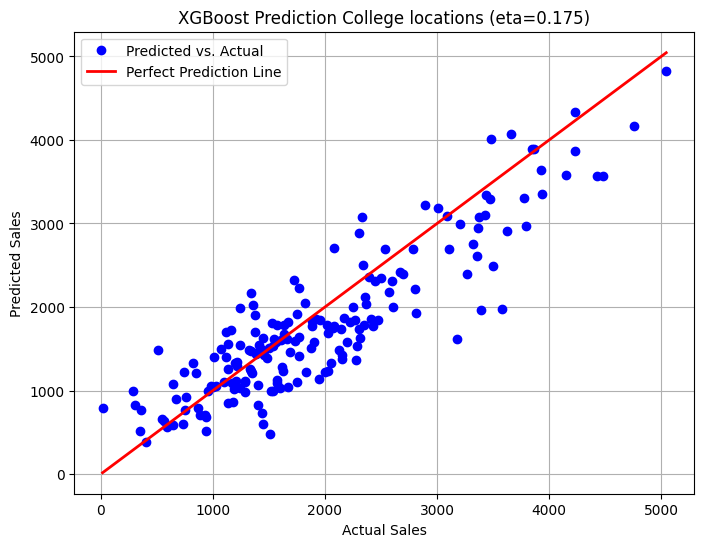

In [9]:
# Choose a specific learning rate
eta = 0.175  # Change this value as needed

# Train the model
xgb_model = xgb.XGBRegressor(learning_rate=eta, n_estimators=np.sqrt(len(Y_train_stand)).astype(int), max_depth=15, random_state=42, eval_metric="error")
xgb_model.fit(X_train_stand, Y_train_stand)

# Make predictions
Y_test_pred = xgb_model.predict(X_test_stand)

# Convert Y_test_stand to a numpy array and then flatten
Y_test_stand = np.array(Y_test_stand).flatten()

# Flatten Y_test_pred if necessary
Y_test_pred = Y_test_pred.flatten()
# Create a DataFrame
results_df = pd.DataFrame({
    'Actual Sales': Y_test_stand,  # Assuming Y_test_stand contains actual values
    'Predicted Sales': Y_test_pred
})

# Display the first few rows
print(results_df.head())



# Plot actual vs predicted sales
plt.figure(figsize=(8, 6))
plt.plot(Y_test_stand, Y_test_pred, 'bo', label='Predicted vs. Actual')  # Scatter plot
plt.plot([min(Y_test_stand), max(Y_test_stand)], [min(Y_test_stand), max(Y_test_stand)], 'r-', lw=2, label='Perfect Prediction Line')  # Reference line
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title(f'XGBoost Prediction College locations (eta={eta})')
plt.legend()
plt.grid()
plt.savefig(f"XGBoost_Sales_Prediction_College_locations_eta_{eta}.png", format="png", dpi=300)
plt.show()

In [10]:
X_train = train_features
Y_train = train_response
X_test = test_features
Y_test = test_response

# Standardize Data (Assuming standardize_data() function works as expected)
X_train_stand, Y_train_stand, X_train_stand_scaler, Y_train_stand_scaler = Standardizer.standardize_data(features=X_train, response=Y_train)
X_test_stand, Y_test_stand, X_test_stand_scaler, Y_test_stand_scaler = Standardizer.standardize_data(features=X_test, response=Y_test)

Y_train_stand = Y_train
Y_test_stand = Y_test

n1 = round(len(data)*0.8)
n2 = round(len(data)*0.2)
b = [100]
# Initialize the result DataFrame
result_df = pd.DataFrame({
    "B Cross Validations": [],
    "Average Error Rate": [],
    "Average Error Variance": []
})

for B in tqdm(b):
    # Reinitialize the lists for storing metrics for each B

    test_error_rates = []
    test_accuracies = []

    for i in range(B):
        
        X_combined = pd.concat([X_train_stand, X_test_stand], axis=0)
        y_combined = pd.concat([Y_train, Y_test], axis=0).values.flatten()

        
        X_train_sample, X_test_sample, Y_train_sample, Y_test_sample = train_test_split(
            X_combined, y_combined, train_size=n1, test_size=n2, random_state=i
        )

        # Train the model on the training data
        xgb_model = xgb.XGBRegressor(learning_rate=eta, n_estimators=np.sqrt(len(Y_train_stand)).astype(int), max_depth=15, random_state=42, eval_metric="error")
        
        # Fit the model
        xgb_model.fit(X_train_stand, Y_train_stand)

        test_predictions = xgb_model.predict(X_test_sample)



        #test_predictions = (test_predictions > 0.5).astype(int)
        #lr.fit(X_train, Y_train)
        

        # Make predictions on the testing data
        
        explained_variance = explained_variance_score(y_true=Y_test_sample, y_pred=test_predictions)
      
      

        # Calculate error rate (MSE)
        nb_test_error_rate = mean_absolute_error(y_true=Y_test_sample, y_pred=test_predictions)

        # Append to the lists

        test_error_rates.append(nb_test_error_rate)
        test_accuracies.append(explained_variance)

    # Calculate the variance of the testing error rates after all iterations for this B
    test_error_variance = np.var(test_error_rates)

    # Calculate the averages for the current B value

    average_test_error_rate = np.mean(test_error_rates)

    
    # metrics_df = pd.DataFrame({
    #     "B Cross Validations": [B],
    #     "Average Error Rate": [average_test_error_rate],
    #     "Average Error Variance": [test_error_variance]
    # })
    metrics_df = pd.DataFrame({
      "B Cross Validations": [B],
      "Average Error Rate": [average_test_error_rate],
      "Average Error Variance": [test_error_variance],
      "Average Explained Variance": [np.mean(test_accuracies)]  # Added Explained Variance
  })

    
    result_df = pd.concat([result_df, metrics_df], axis=0).round(4)


result_df

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:28<00:00, 28.72s/it]


,B Cross Validations,Average Error Rate,Average Error Variance,Average Explained Variance
0,100.0,71.5734,123.3939,0.9569


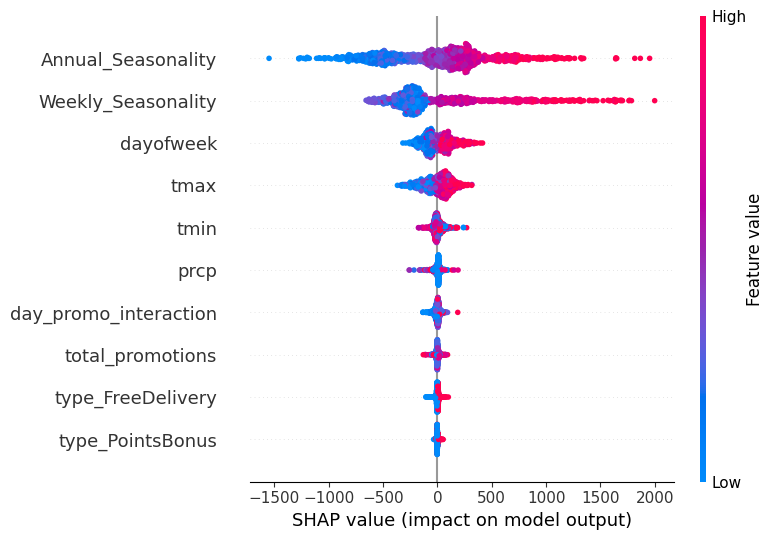

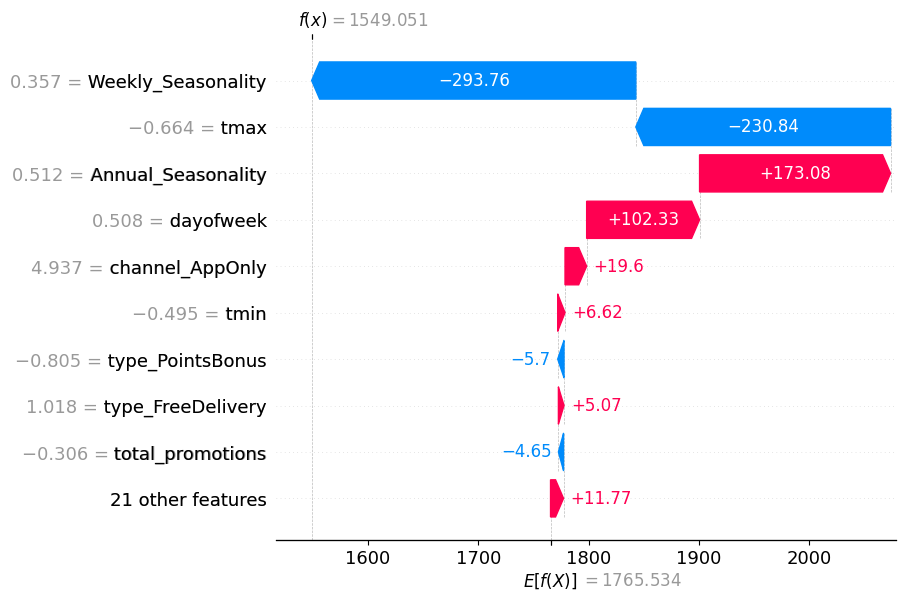

In [13]:
# Assuming you have an XGBoost model (rf is replaced with xgb_model)
explainer = shap.Explainer(xgb_model, X_combined)  # Explain the XGBoost model
shap_values = explainer(X_combined)

# Summary plot
shap.summary_plot(shap_values, X_combined,max_display=10)

shap.plots.waterfall(shap_values[25])

xgb_model.save_model("college_xgboost.json")
X_combined.to_csv("college_xgboost_xvals.csv")